In [4]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import h5py
from crashpy.dataclasses.simulation import LoadedSimulation as Sim

In [5]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# load the config module for the fiducial 2 configuration
spec = importlib.util.spec_from_file_location("module.name","/freya/ptmp/mpa/mglatzle/TNG_f_esc/fid2d/config.py")
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [7]:
print(spec)

ModuleSpec(name='module.name', loader=<_frozen_importlib_external.SourceFileLoader object at 0x2b3ba4221a90>, origin='/freya/ptmp/mpa/mglatzle/TNG_f_esc/fid2d/config.py')


In [8]:
print(config)

<module 'module.name' from '/freya/ptmp/mpa/mglatzle/TNG_f_esc/fid2d/config.py'>


In [9]:
print(spec.loader.exec_module)

<bound method _LoaderBasics.exec_module of <_frozen_importlib_external.SourceFileLoader object at 0x2b3ba4221a90>>


In [10]:
def h5toDict(f):
    """
    Load data from h5py file into a dict.

    This assumes all datasets contained in the h5py file can be converted to
    numpy arrays.

    Parameters
    ----------
    f : h5py.File
        h5py file object to load data from.

    Returns
    -------
    dd : dict
        Dictionary of all group and datasets contained in 'f'. Hierarchical
        structure is kept identical.
    """
    d = {}

    def visitor(name, node):
        if isinstance(node, h5py.Dataset):
            d[name] = np.array(node)
        return 
    
    f.visititems(visitor)

    # restore hierarchical structure as the visitor flattens it
    dd = {}
    for key, val in d.items():
        keys = key.split('/')
        ddd = dd
        for k in keys[:-1]:
            if k in ddd:
                ddd = ddd[k]
            else:
                ddd[k] = {}
                ddd = ddd[k]
        ddd[keys[-1]] = val

    return dd

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
print(config.to_process.items())

dict_items([('L35n2160TNG', [13, 8, 4])])


In [13]:
# dict of dicts, first level is TNG simulation, second level is simulation
# snapshot. For each snapshot, load its header (key 'header') and a halo
# dataframe (key 'df').
halos = {}
for simname, snaps in config.to_process.items():
    sim = config.get_sim(simname)
    halos[simname] = {}
    for snap in snaps:
        dic = {}

        dic['header'] = sim.snap_cat[snap].header

        df = pd.read_pickle(config.selected_halo_df_file(simname, config.snap_name(snap)))
        df['csim_path', 0] = np.nan
        for i in range(config.n_rcs):
            df['f_esc', i] = np.nan
        for ID in config.completed_haloIDs(simname, config.snap_name(snap)):
            rundir = config.rundir(simname, config.snap_name(snap), config.halo_name(ID))
            df.loc[ID, 'csim_path'] = rundir
            csim = Sim(rundir)
            ls = []
            for i, pf in enumerate(csim.getAllphysfiles()):
                with h5py.File(config.f_esc_file(pf)) as f:
                    fesc = h5toDict(f)
                ls.append(fesc)
            df.loc[ID, 'f_esc'] = np.array(ls)
        dic['df'] = df

        halos[simname][config.snap_name(snap)] = dic 

In [10]:
object_methods = [method_name for method_name in dir(config)
                  if callable(getattr(config, method_name))]

In [14]:
# escape fraction of halo 27586 of snapshot 4 at the first CRASH output:
df = halos['L35n2160TNG']['sn004']['df']

In [15]:
df.keys()

MultiIndex([(            'GroupBHMass', 0),
            (            'GroupBHMdot', 0),
            (                'GroupCM', 0),
            (                'GroupCM', 1),
            (                'GroupCM', 2),
            (          'GroupFirstSub', 0),
            ( 'GroupGasMetalFractions', 0),
            ( 'GroupGasMetalFractions', 1),
            ( 'GroupGasMetalFractions', 2),
            ( 'GroupGasMetalFractions', 3),
            ( 'GroupGasMetalFractions', 4),
            ( 'GroupGasMetalFractions', 5),
            ( 'GroupGasMetalFractions', 6),
            ( 'GroupGasMetalFractions', 7),
            ( 'GroupGasMetalFractions', 8),
            ( 'GroupGasMetalFractions', 9),
            (    'GroupGasMetallicity', 0),
            (               'GroupLen', 0),
            (           'GroupLenType', 0),
            (           'GroupLenType', 1),
            (           'GroupLenType', 2),
            (           'GroupLenType', 3),
            (           'GroupLe

In [ ]:
df.sort_values(by=('GroupMass', 0))

In [12]:
f_esc=[]
metal=[]
mass=[]
sfr=[]
for ID in config.completed_haloIDs(simname, config.snap_name(snap)):
    try:
        f_esc.append(float(x['f_esc'][0][ID]['5.0e-2']['1.0e0']['cum']))
        metal.append(x['GroupStarMetallicity'][0][ID])
        mass.append(x['GroupMass'][0][ID])
        sfr.append(x['GroupSFR'][0][ID])
    except:
        pass

In [13]:
x['GroupStarMetallicity'][0].values

array([0.00075348, 0.00139817, 0.00114135, ..., 0.00083715, 0.00085711,
       0.00046831], dtype=float32)

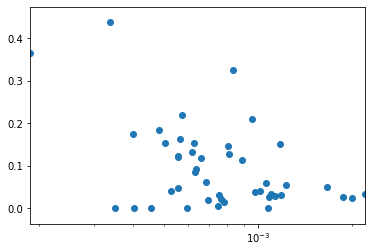

In [17]:
full_range=max(metal)-min(metal)
plt.scatter(metal,f_esc)

plt.xscale('log')
plt.xlim(min(metal), max(metal));

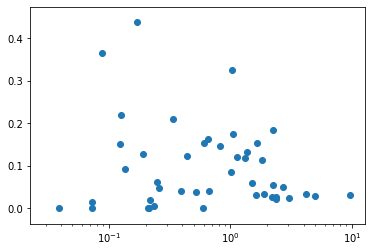

In [15]:
plt.scatter(mass,f_esc)
plt.xscale('log')

(0.0023804952, 3.6609867)

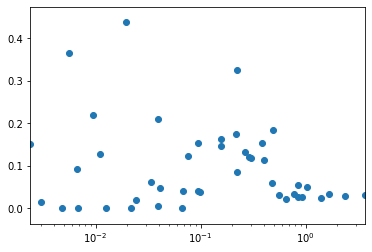

In [16]:
full_range=max(sfr)-min(sfr)
plt.scatter(sfr,f_esc)
plt.xscale('log')
plt.xlim(min(sfr), max(sfr))

In [29]:
max([3,4,6,4])

6

In [30]:
def euclid(n,m):
    left = max([n,m])
    right = min([n,m])
    while True:
        r=left%right
        if r==0:
            print(right)
            break
        left=right
        right=r
        

In [38]:
euclid(51,42)

3
